# Analisis de incertidumbre

Notebook para comparar el performance de LLF cuando los deadlines tienen incertidumbre vs LRPT

In [2]:
#using Pkg;Pkg.instantiate()
#import Pkg; Pkg.add("KernelEstimator")
using EVQueues, Plots, Distributions, DataFrames, LaTeXStrings, KernelEstimator

Se definen los parámetros para realizar las simulaciones

In [3]:
#Incertidumbre (se modela como una Uniforme)
theta=1

#Parámetros del resto de la simulación
lambda=30.0;
mu=0.5;
gamma=0.25;
C=40.0;
Tfinal=200.0;

Funcion con threshold teorico de LLF

In [10]:
function threshold(theta,lambda,mu,C);
    rho = lambda/mu;
    return -1/mu*log( (C/rho)*mu/theta/sinh(mu*theta));
end;

Se simulan el LLF base, con incertidumbre y el LRPT

In [51]:
df = generate_Poisson_stream(lambda,mu,gamma,Tfinal);

#Se corre el algoritmo "base", esto es, considerando los deadlines reales
alg_lrpt = ev_lrpt_trace(df,C);
alg_llf = ev_llf_trace(df,C);

#Se perturban las salidas, y se simula considerandola como la salida reportada
df2 = deepcopy(df)
df2[!,:salidaReportada] = df2[!,:salidas] + rand(Uniform(-theta,theta),nrow(df2))

alg_uncertain = ev_llf_trace(df2,C);
compute_statistics!(alg_uncertain);

alg_lrpt_evs = sort(alg_lrpt.EVs,by=ev->ev.arrivalTime)
alg_uncertain_evs = sort(alg_uncertain.EVs,by=ev->ev.arrivalTime)
alg_llf_evs = sort(alg_llf.EVs,by=ev->ev.arrivalTime)

#para recortar el transitorio
n=Int(Tfinal*lambda/10);
alg_lrpt_evs = alg_lrpt_evs[n:end-n]
alg_uncertain_evs = alg_uncertain_evs[n:end-n]
alg_llf_evs = alg_llf_evs[n:end-n]

#Guardo resultados de vehiculos
S_alg_lrpt = [ev.requestedEnergy for ev in alg_lrpt_evs];
S_alg_uncertain = [ev.requestedEnergy for ev in alg_uncertain_evs];
S_llf = [ev.requestedEnergy for ev in alg_llf_evs];

Sr_alg_lrpt = [ev.departureWorkload for ev in alg_lrpt_evs];
Sr_alg_uncertain = [ev.departureWorkload for ev in alg_uncertain_evs];
Sr_llf = [ev.departureWorkload for ev in alg_llf_evs];

Sa_alg_lrpt = S_alg_lrpt - Sr_alg_lrpt
Sa_alg_uncertain = S_alg_uncertain - Sr_alg_uncertain;
Sa_llf = S_llf - Sr_llf;

Comparasion del threshold teorico para LLF

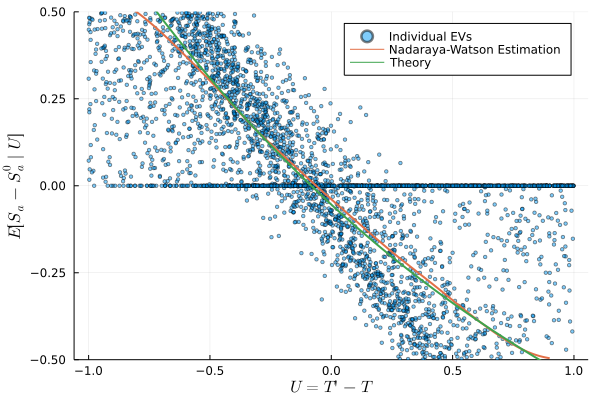

In [54]:
u=(-0.9*theta:0.01:0.9*theta)

alg_departure = [ev.reportedDepartureTime for ev in alg_llf_evs];
alg_uncertain_departure = [ev.reportedDepartureTime for ev in alg_uncertain_evs];
diff_departure=alg_uncertain_departure - alg_departure;

tau = threshold(theta,lambda,mu,C)

Sa2_teo = exp.(-mu*tau)/mu*exp.(-mu*u)
Sa_teo = C/lambda

Sa_hat = localconstant(diff_departure, Sa_alg_uncertain - Sa_llf, xeval=u);

#scatter(diff_departure,Sa_alg_uncertain, label="Individual EVs", ms=2)#, ylims=(-.5,.5))
#scatter!(diff_departure,Sa_llf,alpha=0.5, label="Individual EVs", ms=2)#, ylims=(-.5,.5))
scatter(diff_departure,Sa_alg_uncertain-Sa_llf,alpha=0.5, label="Individual EVs", ms=2, ylims=(-.5,.5))
plot!(u,Sa_hat,lw=2, label="Nadaraya-Watson Estimation", ylims=(-.5,.5))
plot!(u,Sa2_teo.-Sa_teo,lw=2, label="Theory", xlabel=L"U = T '-T", ylabel=L"E[S_a - S_a^0 \mid U]")

A continuación, se plotea la misma gráfica con la selección abierta.
Opciones: "LLF Base", "LLF Uncertain", "LRPT"

In [59]:
Alg1="LLF Uncertain";
Alg2="LLF Base";

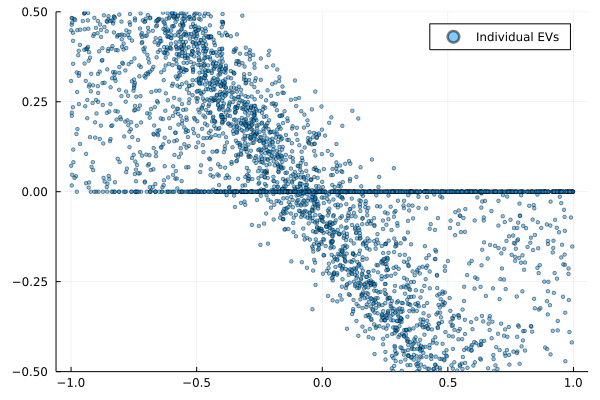

In [60]:
if Alg1 == "LLF Base"
    Sa_alg1=Sa_llf;
    if Alg2 == "LLF Uncertain"
        Sa_alg2=Sa_alg_uncertain;
    end
    if Alg2 == "LRPT"
        Sa_alg2=Sa_alg_lrpt;        
    end        
end
if Alg1 == "LLF Uncertain"
    Sa_alg1=Sa_alg_uncertain;
    if Alg2 == "LLF Base"
        Sa_alg2=Sa_llf;
    end
    if Alg2 == "LRPT"
        Sa_alg2=Sa_alg_lrpt;
    end        
end
if Alg1 == "LRPT"
    Sa_alg1=Sa_alg_lrpt;
    if Alg2 == "LLF Base"
        Sa_alg2=Sa_llf;
    end
    if Alg2 == "LLF Uncertain"
        Sa_alg2=Sa_alg_uncertain;
    end        
end

scatter(diff_departure,Sa_alg1-Sa_alg2,alpha=0.5, label="Individual EVs", ms=2, ylims=(-.5,.5))

Plot de energía recibida por cada vehículo, en un algoritmo y en otro

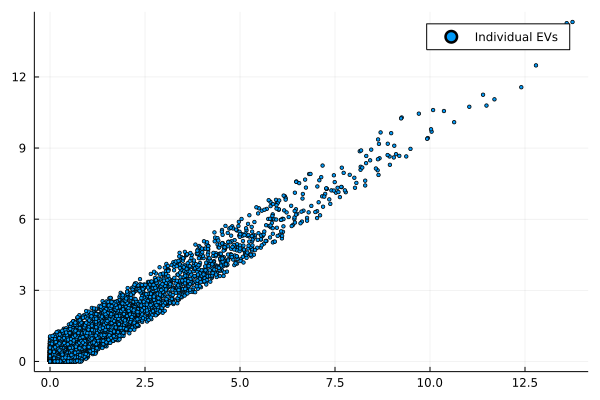

In [61]:
scatter(Sa_alg1,Sa_alg2, label="Individual EVs", ms=2)

Analisis con Curtail

In [35]:
function llfc_policy(evs,C)

    if length(evs)==0
        #nothing to do, return empty array for consistence
        U=Array{Float64}(undef,0);
    else
        deadlines = [ev.currentReportedDeadline for ev in evs];
        laxities = [ev.currentReportedDeadline-ev.currentWorkload/ev.chargingPower for ev in evs];

        positivas = findall(deadlines.>0)
        negativas = findall(deadlines.<=0)
        
        perm1 = sortperm(laxities[positivas]);
        perm2 = sortperm(laxities[negativas], rev=true);
        
        perm = [positivas[perm1];negativas[perm2]]
           
        p=0.0;
        i=1;
        U=zeros(length(evs));

        #recorro el vector en orden de deadline y le asigno su potencia maxima o lo que falte pare llegar a C (puede ser 0)
        while p<C && i<=length(evs)
            alloc = min(evs[perm[i]].chargingPower,C-p);
            p=p+alloc;
            U[perm[i]]=alloc;
            i=i+1;
        end

    end
    return U;
end;

Se simulan el LLF base, con incertidumbre (y curtail) y el LRPT

In [36]:
df = generate_Poisson_stream(lambda,mu,gamma,Tfinal);

#Se corre el algoritmo "base", esto es, considerando los deadlines reales
alg = ev_lrpt_trace(df,C);
alg_llf = ev_llf_trace(df,C);

#Se perturban las salidas, y se simula considerandola como la salida reportada
df2 = deepcopy(df)
df2[!,:salidaReportada] = df2[!,:salidas] + rand(Uniform(-theta,theta),nrow(df2))

alg_uncertain = ev_sim_trace(df2,llfc_policy,C,[Inf]);
compute_statistics!(alg_uncertain);

alg_lrpt_evs = sort(alg_lrpt.EVs,by=ev->ev.arrivalTime)
alg_uncertain_evs = sort(alg_uncertain.EVs,by=ev->ev.arrivalTime)
alg_llf_evs = sort(alg_llf.EVs,by=ev->ev.arrivalTime)


#para recortar el transitorio
n=Int(Tfinal*lambda/10);
alg_lrpt_evs = alg_lrpt_evs[n:end-n]
alg_uncertain_evs = alg_uncertain_evs[n:end-n]
alg_llf_evs = alg_llf_evs[n:end-n]

#Guardo resultados de vehiculos
S_alg_lrpt = [ev.requestedEnergy for ev in alg_lrpt_evs];
S_alg_uncertain = [ev.requestedEnergy for ev in alg_uncertain_evs];
S_llf = [ev.requestedEnergy for ev in alg_llf_evs];

Sr_alg_lrpt = [ev.departureWorkload for ev in alg_lrpt_evs];
Sr_alg_uncertain = [ev.departureWorkload for ev in alg_uncertain_evs];
Sr_llf = [ev.departureWorkload for ev in alg_llf_evs];

Sa_alg_lrpt = S_alg_lrpt - Sr_alg_lrpt
Sa_alg_uncertain = S_alg_uncertain - Sr_alg_uncertain;
Sa_llf = S_llf - Sr_llf;

Funcion threshold teorico

In [37]:
function threshold2(theta,lambda,mu,C)
    rho = lambda/mu
    ktheta = (1/2 + (1-exp(-mu*theta)/(2*mu*theta)))
    return -1/mu*log( C/rho*(1/ktheta))
end;

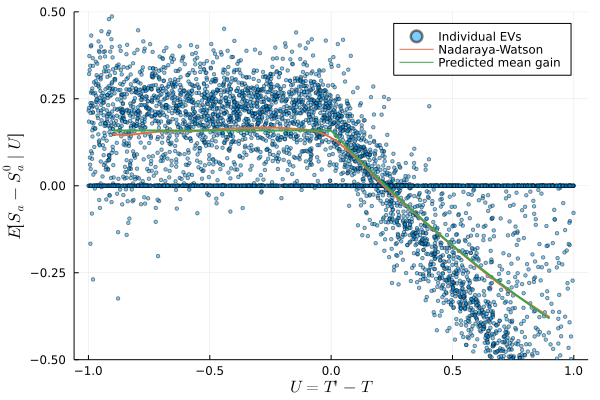

In [39]:
u=(-0.9*theta:0.01:0.9*theta)

alg_departure = [ev.reportedDepartureTime for ev in alg_llf_evs];
alg_uncertain_departure = [ev.reportedDepartureTime for ev in alg_uncertain_evs];
diff_departure=alg_uncertain_departure - alg_departure;


tau2 = threshold2(theta,lambda,mu,C)
Sa3_teo = (exp.(-mu*(tau2.+max.(u,0))))/mu
Sa_teo = C/lambda

Sa_hat = localconstant(diff_departure, Sa_alg_uncertain - Sa_llf, xeval=u);

scatter(diff_departure,Sa_alg_uncertain-Sa_llf,alpha=0.5, label="Individual EVs", ms=2, ylims=(-.5,.5))
plot!(u,Sa_hat,lw=2, label="Nadaraya-Watson", ylims=(-.5,.5))
plot!(u,Sa3_teo.-Sa_teo,lw=2, label="Predicted mean gain", xlabel=L"U = T '-T", ylabel=L"E[S_a - S_a^0 \mid U]")

A continuación, se plotea la misma gráfica con la selección abierta.
Opciones: "LLF Base", "LLF Uncertain", "LRPT"

In [49]:
Alg1="LLF Uncertain";
Alg2="LRPT";

In [50]:
if Alg1 == "LLF Base"
    Sa_alg1=Sa_llf;
    if Alg2 == "LLF Uncertain"
        Sa_alg2=Sa_alg_uncertain;
    end
    if Alg2 == "LRPT"
        Sa_alg2=Sa_alg_lrpt;        
    end        
end
if Alg1 == "LLF Uncertain"
    Sa_alg1=Sa_alg_uncertain;
    if Alg2 == "LLF Base"
        Sa_alg2=Sa_llf;
    end
    if Alg2 == "LRPT"
        Sa_alg2=Sa_alg_lrpt;
    end        
end
if Alg1 == "LRPT"
    Sa_alg1=Sa_alg_lrpt;
    if Alg2 == "LLF Base"
        Sa_alg2=Sa_llf;
    end
    if Alg2 == "LLF Uncertain"
        Sa_alg2=Sa_alg_uncertain;
    end        
end

scatter(diff_departure,Sa_alg1-Sa_alg2,alpha=0.5, label="Individual EVs", ms=2, ylims=(-.5,.5))

LoadError: DimensionMismatch("dimensions must match: a has dims (Base.OneTo(4861),), b has dims (Base.OneTo(4812),), mismatch at 1")

Plot de energía recibida por cada vehículo, en un algoritmo y en otro

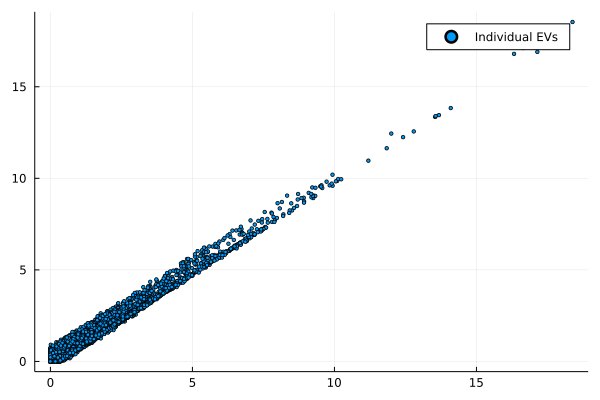

In [42]:
scatter(Sa_alg1,Sa_alg2, label="Individual EVs", ms=2)